In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Set Constant

In [18]:
BATCH_SIZE = 32
CHANNELS = 3
IMAGE_SIZE = 256
EPCHOS = 50

# Load Dataset

In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/happy-or-sad-image',
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 305 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['happy', 'sad']

Checking Shape

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 299, 299, 3)
[1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1]


#  Visualize some of the images from our dataset


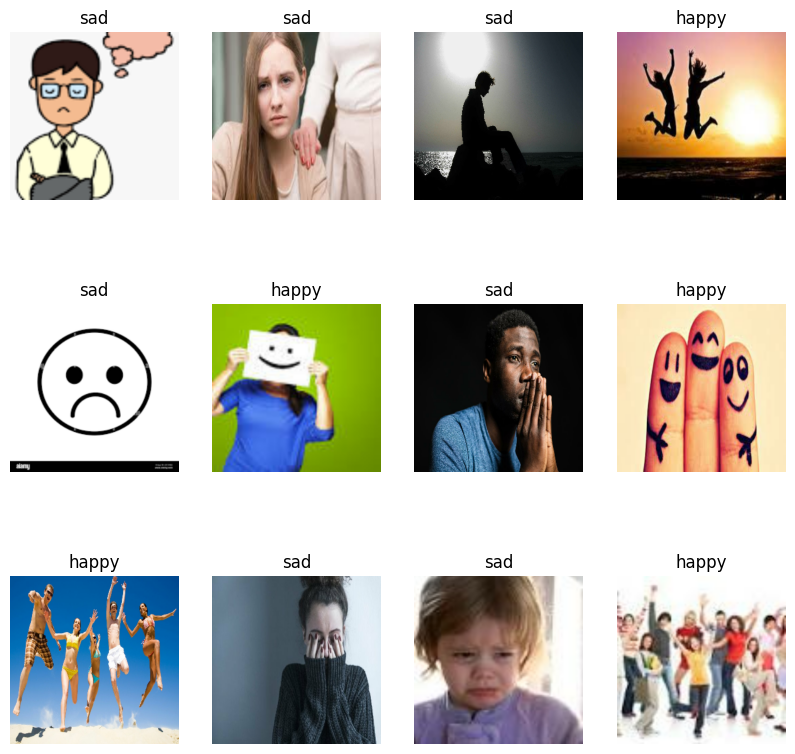

In [6]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
        
    plt.show()

# Spliting Dataset

In [7]:
def get_partition_dataset(ds, train_split=0.8, test_split = 0.1, val_split=0.1, shuffle = True, shuffle_size= 1000):
    assert (train_split + test_split +val_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, test_ds, val_ds
    

In [8]:
train_ds, test_ds, val_ds = get_partition_dataset(dataset)

In [9]:
len(train_ds)

8

In [10]:
len(test_ds)

1

In [11]:
len(val_ds)

1

# Cache, Shuffle, and Prefetch the Dataset¶


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

# Model Building

Resizing and Normalizaion

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    
    layers.experimental.preprocessing.Rescaling(0.1 / 299)
])

# Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Data Augmentation to Train Dataset

In [15]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size= tf.data.AUTOTUNE)

# Model Architecture

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])
model.build(input_shape=input_shape)

# Early Stopping

using early stopping is beneficial because it helps prevent overfitting and can save computation time. Instead of training the model for a fixed number of epochs, you allow it to stop early if it's not learning effectively, potentially saving resources and avoiding unnecessary computation. This is especially useful when running experiments in a Kaggle environment with limited computation resources.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [22]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )

In [23]:
history= model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=500,
    callbacks=callback)

Epoch 1/500
8/8 [==============================] - 6s 369ms/step - loss: 0.7003 - accuracy: 0.5039 - val_loss: 0.6815 - val_accuracy: 0.6250
Epoch 2/500
8/8 [==============================] - 3s 379ms/step - loss: 0.6945 - accuracy: 0.5117 - val_loss: 0.6846 - val_accuracy: 0.6250
Epoch 3/500
8/8 [==============================] - 3s 398ms/step - loss: 0.6914 - accuracy: 0.5117 - val_loss: 0.6788 - val_accuracy: 0.6250
Epoch 4/500
8/8 [==============================] - 3s 393ms/step - loss: 0.6854 - accuracy: 0.5977 - val_loss: 0.6541 - val_accuracy: 0.6250
Epoch 5/500
8/8 [==============================] - 3s 391ms/step - loss: 0.6378 - accuracy: 0.6172 - val_loss: 0.5866 - val_accuracy: 0.5625
Epoch 6/500
8/8 [==============================] - 3s 398ms/step - loss: 0.6493 - accuracy: 0.5977 - val_loss: 0.5124 - val_accuracy: 0.5938
Epoch 7/500
8/8 [==============================] - 3s 399ms/step - loss: 0.6105 - accuracy: 0.6172 - val_loss: 0.5925 - val_accuracy: 0.6562
Epoch 8/500
8

In [24]:
model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.3693 - accuracy: 0.7812


[0.3692961037158966, 0.78125]

In [26]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [28]:
loss = history.history['loss']
val_loss  = history.history['val_loss']

# Visualize accuracy and loss

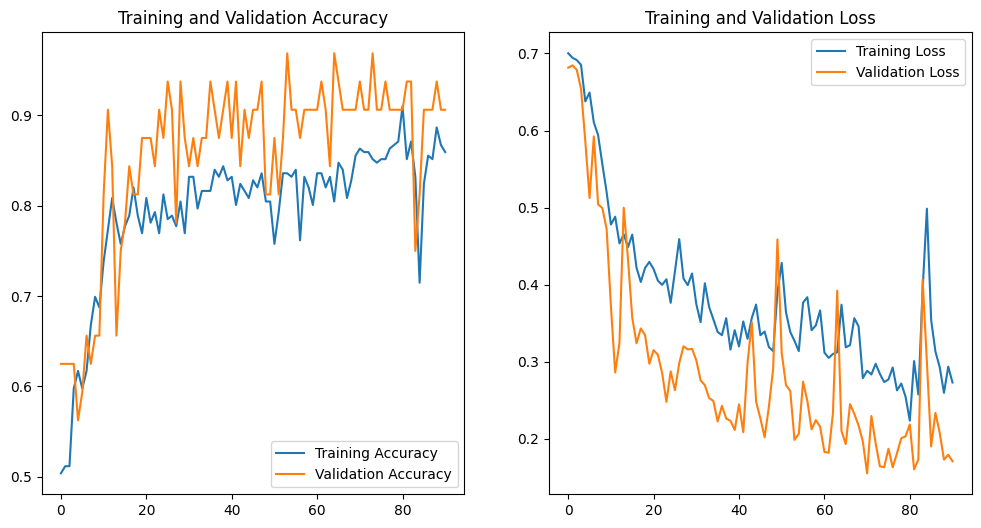

In [30]:
EPOCHSS = len(acc)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHSS), acc, label='Training Accuracy')
plt.plot(range(EPOCHSS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHSS), loss, label='Training Loss')
plt.plot(range(EPOCHSS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Save Model

In [31]:
import os

# List comprehension to filter out non-integer entries
model_versions = [int(i) for i in os.listdir("/kaggle/working/") if i.isdigit()]

# Get the maximum version or default to 0 if the list is empty
model_version = max(model_versions, default=0) + 1

model.save(f"/kaggle/working/{model_version}")
model.save("../Reaction.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
import shutil
# from google.colab import files

# Specify the folder path on Kaggle
folder_path_on_kaggle = "/kaggle/working/1"

# Specify the local destination path for the zip file
local_zip_destination = "downloaded_folder.zip"

# Create a zip file of the folder
shutil.make_archive(local_zip_destination[:-4], 'zip', folder_path_on_kaggle)
'/kaggle/working/downloaded_folder.zip'

'/kaggle/working/downloaded_folder.zip'